In [1]:
using CUDA
using Test
using BenchmarkTools

using Plots
using LaTeXStrings
using Colors, ColorSchemes
cs1 = ColorScheme(range(colorant"red", colorant"royalblue1", length=5));

using QuadGK

using Base.Threads: @threads, @spawn
ENV["JULIA_NUM_THREADS"]

"64"

In [2]:
include("qts.jl")
include("brentq.jl")
include("fields.jl")

psi_s_case_E (generic function with 1 method)

# Parameters

In [3]:
const rho = 1.5
const gamma = 5000.0
const phi = 0.2

const beta = (1-1/gamma^2)^(1/2)
# lamb = 0.01/rho

# const phi_m = 0.5/rho

sigma_z = 50e-6
sigma_x = 50e-6

5.0e-5

# Functions

In [9]:
function QTS_case_B(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, xp::Float64)
    
    ## define function here
    sigma_x  = 50e-6
    sigma_z  = 50e-6
    lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2)    

    ## integral    
    #iii(z::Float64) =  Fx_case_B_SC((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma)*lamb_2d(z,xp)
    iii(z::Float64) =  Es_case_B((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma)*lamb_2d(z,xp)
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho
    zi = rho*(phi - beta*sqrt(chi^2 + 4*(1 + chi)*sin(phi/2)^2))
    zo = -beta*abs(x_ob - xp)

#####################################
    # find critical alpha

    # These came from Es_case_B

    kap(alp::Float64) = sqrt(chi^2 + 4*(1+chi)*sin(alp)^2)
    
    #N1(alp::Float64) = sin(2*alp) - beta*kap(alp)
    N2(alp::Float64) = (1+chi)*sin(2*alp) - beta*kap(alp)
    #D(alp::Float64) = kap(alp) - beta*(1+chi)*sin(2*alp)

    alp_crit2_found = true
    
    alp_crit2 = find_root_Will(N2, 0.0, 0.03, 2000)
    
    if alp_crit2 == -1.0
       alp_crit2_found = false
    end

    #println("alp_crit2: ", alp_crit2)
    
    alp_crit2_usable = false

    if alp_crit2_found == true
        z_crit2  = z_ob - 2*rho*(alp_crit2 - beta*kap(alp_crit2)/2)  
        if (z_crit2 > z_ob - zi) && (z_crit2 < z_ob - zo)
            alp_crit2_usable = true
        end
    end        
        
    
    # TESTING
    if (alp_crit2_usable == true)
        #println("ONLY USING N2 BP :", alp_crit2, ",  ",  z_crit2)

        #zp1 = z_crit2 - 2E-10
        zp2 = z_crit2
        #zp3 = z_crit2 + 2E-10
    
        i1 = QTS_will(iii, z_ob - zi, zp2)  
        i4 = QTS_will(iii, zp2, z_ob - zo) 
        
        return i1+i4
        
    else
        
        if (z_ob - zi < 0.0) && (0.0 < z_ob - zo)
            
            #return QTS_will(iii, z_ob - zi, z_ob - zo) 
            
            #println("USING ZERO!!!")
            i1 = QTS_will(iii, z_ob - zi, 0.0) 
            i2 = QTS_will(iii, 0.0, z_ob - zo) 
            return i1 + i2
            
        else
            #println("USING NO BP!!!")
            return QTS_will(iii, z_ob - zi, z_ob - zo) 
            
        end
        
    end
    
end 

QTS_case_B (generic function with 1 method)

In [11]:
QTS_case_B(1E-6, 1E-6, gamma, 0.02, 0.0)

-1.924483385735016e10

In [25]:
function compute_Ws_case_B(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, nxp::Int)
    sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #for testing only
    #qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        #println("xp_vec:", xp_vec[i])
        #qvec[i] = QTS_case_B_2(z_ob, x_ob, gamma, phi, xp_vec[i])  # for testing
        #println("integral:", qvec[i])
        sum += QTS_case_B(z_ob, x_ob, gamma, phi, xp_vec[i])   # for CPU only
        
    end
    
    #return qvec
    return sum* dxp*beta^2/rho^2
end

compute_Ws_case_B (generic function with 1 method)

In [27]:
compute_Ws_case_B(0.0, 0.0, gamma, 0.2, 101)

-230305.12848585428

# Wake computation with GPU

#### simple test (4 observation points only)

In [32]:
zo_vec = CuArray([0.0, 1E-6, 2E-6, 3E-6])
#int_vec = similar(zo_vec)
Ws_vec = similar(zo_vec)

function qts_gpu!(Ws_vec, zo_vec::CuDeviceArray)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(zo_vec)
        #f(z) = (z-zo_vec[i])^2  # test function with zo as a parameter
        Ws_vec[i] = compute_Ws_case_B(Ws_vec[i], 0.0, gamma, phi, 101)
        #int_vec[i] = QTS_case_B(zo_vec[i], 0.0, gamma, 0.2, 0.0) 
    end
    return nothing
end

@cuda threads=4 qts_gpu!(Ws_vec, zo_vec)

CUDA.HostKernel{typeof(qts_gpu!), Tuple{CuDeviceVector{Float64, 1}, CuDeviceVector{Float64, 1}}}(qts_gpu!, CuContext(0x0000000004317200, instance 3d7dcc74f9d0eb63), CuModule(Ptr{Nothing} @0x000000000e14b600, CuContext(0x0000000004317200, instance 3d7dcc74f9d0eb63)), CuFunction(Ptr{Nothing} @0x000000000d52b020, CuModule(Ptr{Nothing} @0x000000000e14b600, CuContext(0x0000000004317200, instance 3d7dcc74f9d0eb63))), CUDA.KernelState(Ptr{Nothing} @0x0000155377c00000))

### 2D observation grid definition 

In [16]:
nz = 201
nx = 101
AA = CuArray{Float64}(undef, nz, nx);

In [17]:
zv = LinRange(-5*sigma_z, 5*sigma_z, nz);
xv = LinRange(-5*sigma_x, 5*sigma_x, nx);

In [18]:
sigma_z = 50e-6
sigma_x = 50e-6

dz = (5*sigma_z - (-5*sigma_z))/(nz-1)
dx = (5*sigma_x - (-5*sigma_x))/(nx-1)

Δ = (dz, dx)

(2.5e-6, 5.0e-6)

### GPU computation ( indexing template from Chris Mayes )

In [76]:
function fillwake!(A::CuDeviceArray, Δ)
    
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    dz, dx = Δ
    nz, nx =  size(A) 
    for i = index:stride:length(A)
        ij = @inbounds CartesianIndices(A)[i]

        z = dz*(ij[1]-1 - (nz-1)/2)
        x = dx*(ij[2]-1 - (nx-1)/2)

        #@inbounds A[i] = f(z, x)
        
        @inbounds A[i] = compute_Wx_case_B(z, x, gamma, phi, 101)
    end
    
end

fillwake! (generic function with 1 method)

In [77]:
# GPU parameters

Ncu = length(AA)
kernel = @cuda launch=false fillwake!(AA, Δ)
config = launch_configuration(kernel.fun)
threads = min(Ncu, config.threads)
blocks = cld(Ncu, threads)
threads, blocks

(256, 80)

In [21]:
# Fill on the device
# This cell can take time!

CUDA.@time CUDA.@sync kernel(AA, Δ; threads, blocks);

101.348807 seconds (223.40 k CPU allocations: 12.362 MiB)


In [273]:
# How William ran gpu

#function bench_gpu2!(AA, Δ)
#    CUDA.@sync begin
#        @cuda threads=1024 blocks=cld(length(AA), 1024) fillwake!(AA, Δ)
#    end
#end

#@time bench_gpu2!(AA, Δ)

bench_gpu2! (generic function with 2 methods)

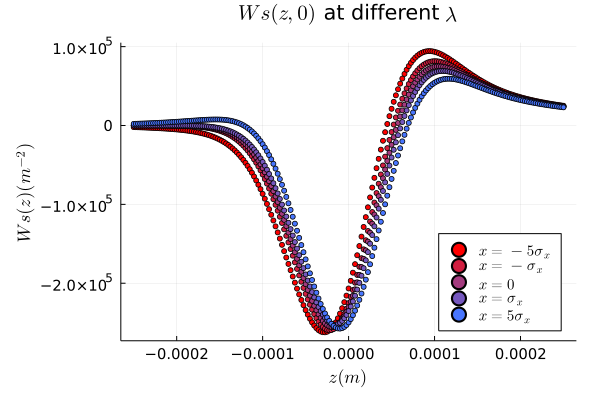

In [72]:
plot(zv, AA[:,1], linewidth=2, label=L"x=-5\sigma_x", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(zv, AA[:,41], linewidth=2, label=L"x=-\sigma_x", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(zv, AA[:,51], linewidth=2, label=L"x=0", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(zv, AA[:,61], linewidth=2, label=L"x=\sigma_x", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(zv, AA[:,101], linewidth=2, label=L"x=5\sigma_x", markersize = 3, seriestype = :scatter, color=cs1[5])

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

In [33]:
AA_cpu = Array(AA);

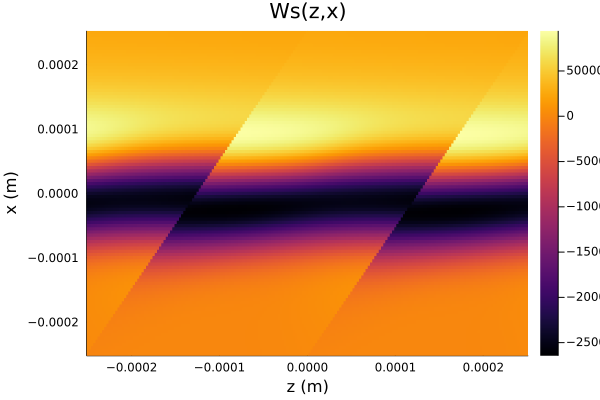

In [73]:
heatmap(zv, xv, AA_cpu, xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

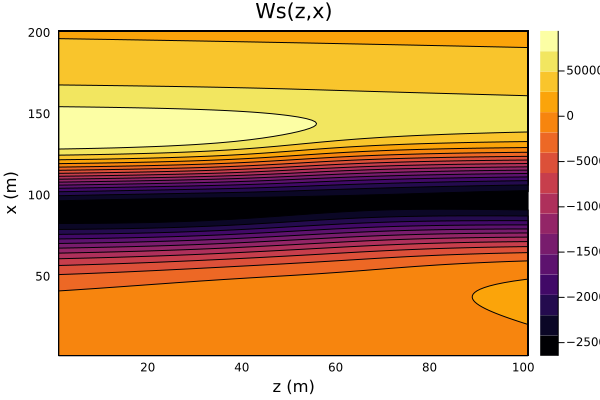

In [78]:
contourf(AA, xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")